In [ ]:
from IPython.display import Markdown as md
import datetime
import os
try:
    os.chdir(os.path.join(os.getcwd(), '../'))
    print(os.getcwd())
except:
    pass

In [2]:
# Configure opentelemetry. This has to be done before we import anything we want to trace

from opentelemetry import trace
from opentelemetry.exporter import jaeger
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import BatchExportSpanProcessor
from opentelemetry.instrumentation.requests import RequestsInstrumentor

RequestsInstrumentor().instrument()
trace.set_tracer_provider(TracerProvider())
jaeger_exporter = jaeger.JaegerSpanExporter(
    service_name="COVID-19-notebook",
    agent_host_name="localhost",
    agent_port=6831,
)
span_processor = BatchExportSpanProcessor(jaeger_exporter)
trace.get_tracer_provider().add_span_processor(span_processor)
tracer = trace.get_tracer(__name__)

# Poland daily data

In [3]:
import figures
import wikipedia_poland_stats as wiki

NO_OF_DAYS = 90

df = wiki.covid_19_timeline()


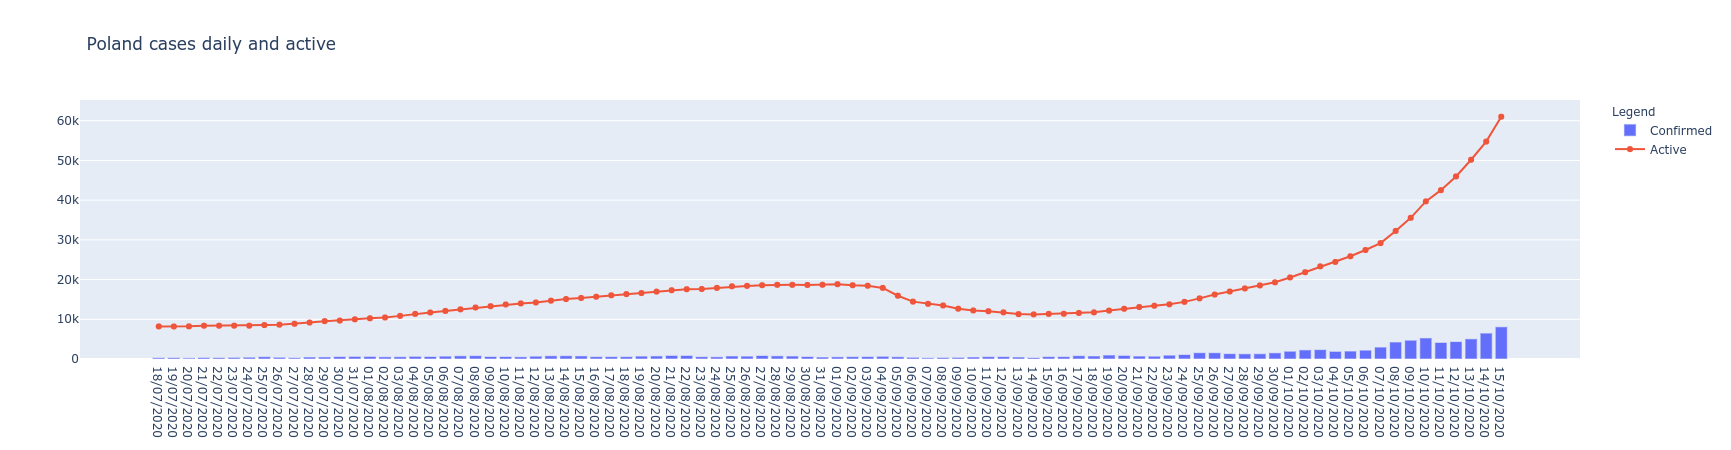

In [4]:
figures.cases_and_active(df, NO_OF_DAYS, 'Poland cases daily and active').show()

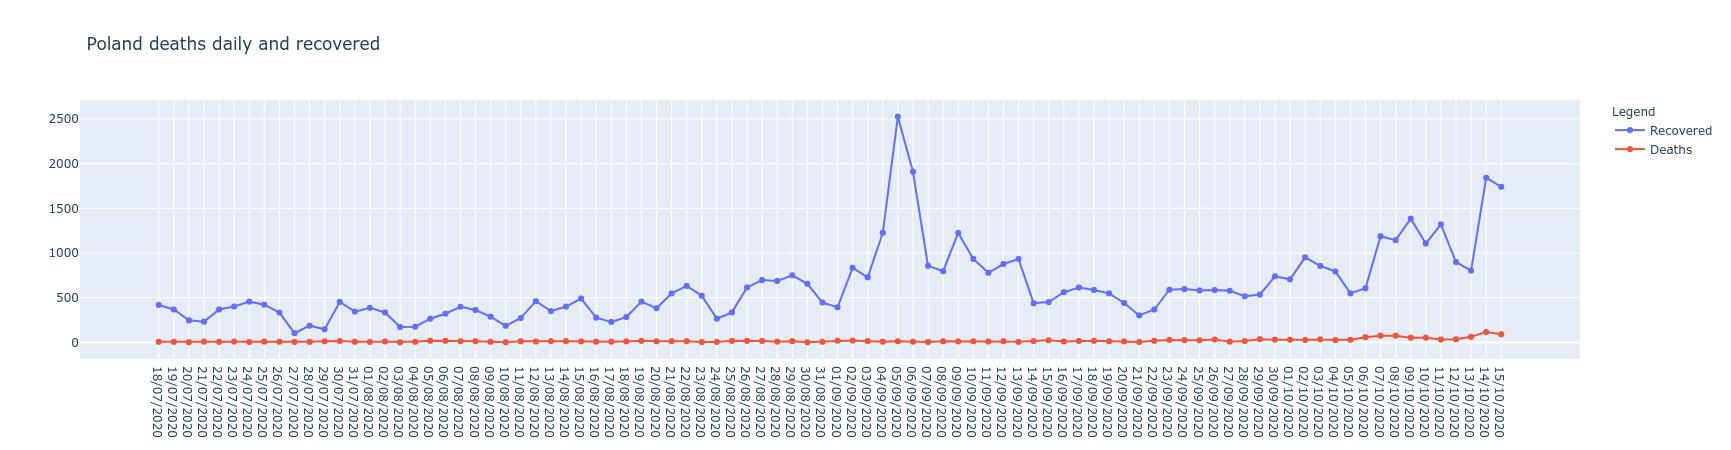

In [5]:
figures.deaths_and_recovered(df, NO_OF_DAYS, 'Poland deaths daily and recovered').show()

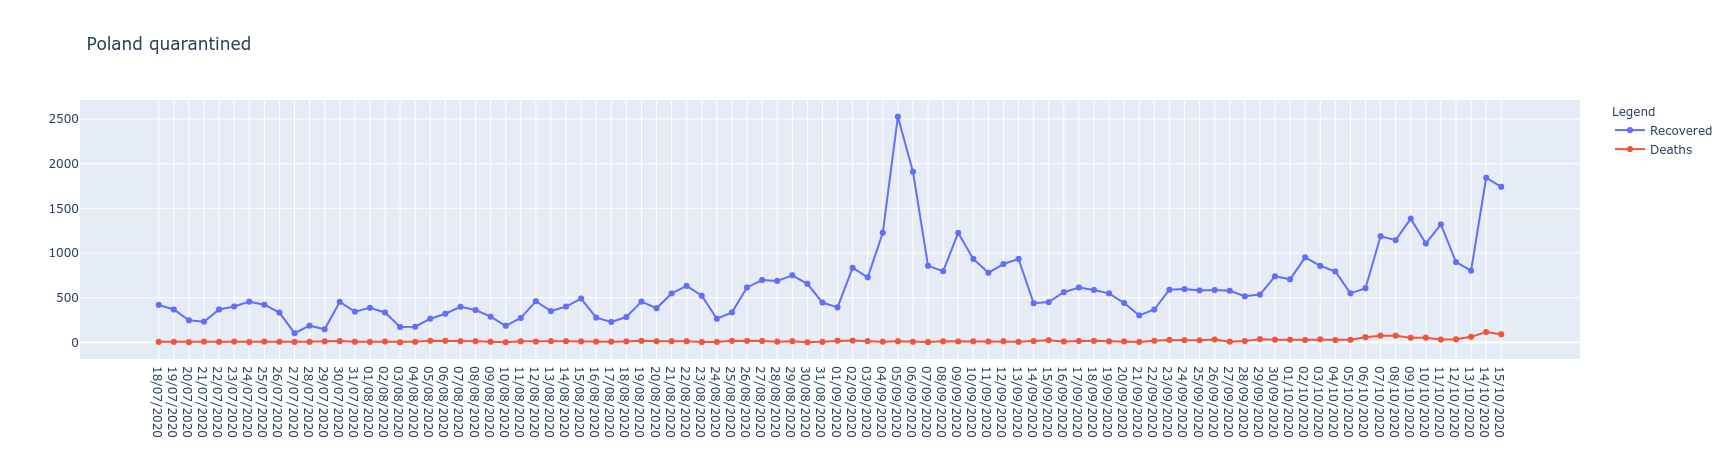

In [6]:
figures.deaths_and_recovered(df, NO_OF_DAYS, 'Poland quarantined').show()

# Poland and few neighbors weekly

We may combine cases and deaths rates with testing against covid-19 and hospital admission rates if we collect data on a weekly basis

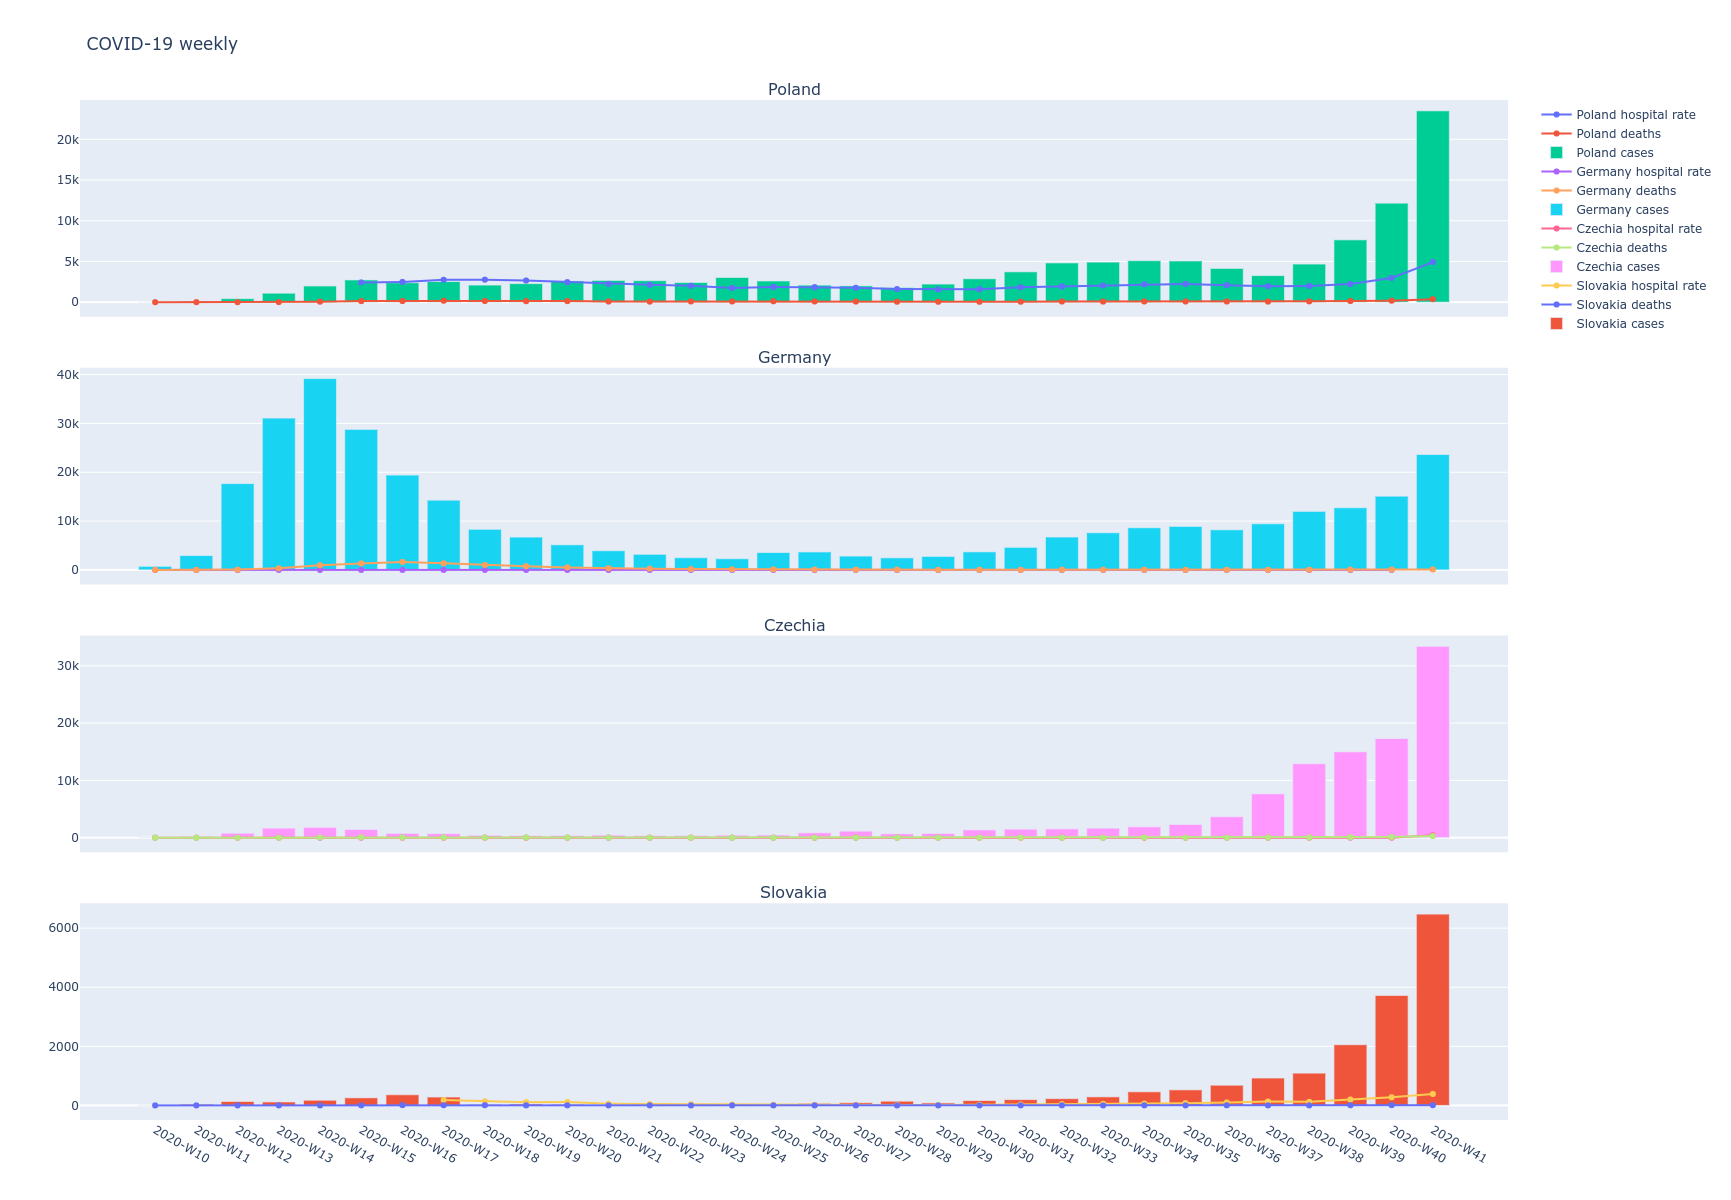

In [7]:
import ecdc
import trends


cases = ecdc.cases_by_country()
countries = ('Poland', 'Germany', 'Czechia', 'Slovakia')
countries_data = []

with tracer.start_as_current_span(f'Countries weekly'):
    testing = ecdc.testing_by_country_weekly()
    hospital_rates = ecdc.hospitel_admission_rates_weekly()
    for c in countries:
        data = trends.weekly(cases, c, testing, hospital_rates)
        countries_data.append(data[0:-1]) # drop current week
        
    figures.case_distribution_subplots(countries_data, countries, "COVID-19 weekly").show()